# 6章 物流の最適ルートをコンサルティングする１０本ノック

ここでは、「物流」の基礎となる「輸送最適化」を検討するにあたっての基礎的な技術を習得します。  
実際の物流データからネットワーク構造を可視化する方法について学び、最適な物流計画を立案する流れを学んでいきます。

### ノック５１：物流に関するデータを読み込んでみよう

In [1]:
import pandas as pd
# 工場データ
factories = pd.read_csv('./tbl_factory.csv')
print(len(factories))
factories

8


,FCID,FCName,FCDemand,FCRegion
0,FC00001,東京工場,28,関東
1,FC00002,木更津工場,29,関東
2,FC00003,多摩工場,31,関東
3,FC00004,横須賀工場,25,関東
4,FC00005,仙台工場,21,東北
5,FC00006,山形工場,30,東北
6,FC00007,那須工場,25,東北
7,FC00008,青森工場,16,東北


In [2]:
# 倉庫データ
warehouses = pd.read_csv('./tbl_warehouse.csv')
print(len(warehouses))
warehouses

6


,WHID,WHName,WHSupply,WHRegion
0,WH00001,杉並倉庫,35,関東
1,WH00002,品川倉庫,41,関東
2,WH00003,豊洲倉庫,42,関東
3,WH00004,郡山倉庫,60,東北
4,WH00005,仙台倉庫,72,東北
5,WH00006,山形倉庫,65,東北


In [4]:
# 輸送取引データ
trans = pd.read_csv('./tbl_transaction.csv')
print(len(trans))
trans.head()

4000


,TRID,TransactionDate,ToFC,FromWH,Quantity
0,0,2019-01-01 02:11:10,FC00004,WH00003,33
1,1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2,2019-01-01 06:32:32,FC00006,WH00004,31
3,3,2019-01-01 07:17:06,FC00002,WH00003,18
4,4,2019-01-01 07:52:18,FC00001,WH00002,30


In [5]:
# コストデータ
cost = pd.read_csv('./rel_cost.csv')
print(len(cost))
cost.head()

24


,RCostID,FCID,WHID,Cost
0,1,FC00001,WH00001,0.4
1,2,FC00001,WH00002,0.8
2,3,FC00001,WH00003,1.5
3,4,FC00002,WH00001,0.9
4,5,FC00002,WH00002,0.8


In [6]:
# transactionsに各テーブルデータをマージ
join_data = pd.merge(trans, cost, left_on=['ToFC','FromWH'], right_on=['FCID', 'WHID'], how='left')
join_data.head()

,TRID,TransactionDate,ToFC,FromWH,Quantity,RCostID,FCID,WHID,Cost
0,0,2019-01-01 02:11:10,FC00004,WH00003,33,12,FC00004,WH00003,1.1
1,1,2019-01-01 06:12:42,FC00007,WH00006,19,21,FC00007,WH00006,1.3
2,2,2019-01-01 06:32:32,FC00006,WH00004,31,16,FC00006,WH00004,0.9
3,3,2019-01-01 07:17:06,FC00002,WH00003,18,6,FC00002,WH00003,1.6
4,4,2019-01-01 07:52:18,FC00001,WH00002,30,2,FC00001,WH00002,0.8


In [7]:
# join_dataとfactoriesを結合
join_data = pd.merge(join_data, factories, left_on='ToFC', right_on='FCID', how='left')
join_data.head()

,TRID,TransactionDate,ToFC,FromWH,Quantity,RCostID,FCID_x,WHID,Cost,FCID_y,FCName,FCDemand,FCRegion
0,0,2019-01-01 02:11:10,FC00004,WH00003,33,12,FC00004,WH00003,1.1,FC00004,横須賀工場,25,関東
1,1,2019-01-01 06:12:42,FC00007,WH00006,19,21,FC00007,WH00006,1.3,FC00007,那須工場,25,東北
2,2,2019-01-01 06:32:32,FC00006,WH00004,31,16,FC00006,WH00004,0.9,FC00006,山形工場,30,東北
3,3,2019-01-01 07:17:06,FC00002,WH00003,18,6,FC00002,WH00003,1.6,FC00002,木更津工場,29,関東
4,4,2019-01-01 07:52:18,FC00001,WH00002,30,2,FC00001,WH00002,0.8,FC00001,東京工場,28,関東


In [8]:
# join_dataとwarehousesを結合
join_data = pd.merge(join_data, warehouses, left_on='FromWH', right_on='WHID', how='left')
# カラムの並び替え
join_data = join_data[['TransactionDate', 'Quantity', 'Cost', 'ToFC', 'FCName', 'FCDemand', 'FromWH', 'WHName', 'WHSupply', 'WHRegion']]
join_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東


In [9]:
# WHRegionが関東になっているデータを抽出
kanto = join_data.loc[join_data['WHRegion'] == '関東']
kanto.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東
7,2019-01-01 09:09:30,12,1.5,FC00001,東京工場,28,WH00003,豊洲倉庫,42,関東
8,2019-01-01 10:52:55,27,1.5,FC00003,多摩工場,31,WH00003,豊洲倉庫,42,関東


In [10]:
# WHRegionが東北になっているデータを抽出
tohoku = join_data.loc[join_data['WHRegion'] == '東北']
tohoku.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
5,2019-01-01 08:56:09,31,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北
6,2019-01-01 09:00:15,33,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
9,2019-01-01 14:12:51,21,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北


### ノック５２：現状の輸送量、コストを確認してみよう

In [11]:
# strでCostを文字変換しながら両脇の文字と接続
print('関東支社の総コスト'+str(kanto['Cost'].sum())+'万円')
print('東北支社の総コスト'+str(tohoku['Cost'].sum())+'万円')

関東支社の総コスト2189.3万円
東北支社の総コスト2062.0万円


In [12]:
# strでQuantityを文字変換しながら両脇の文字と接続
print('関東支社の総部品輸送個数'+str(kanto['Quantity'].sum())+'万円')
print('東北支社の総部品輸送個数'+str(tohoku['Quantity'].sum())+'万円')

関東支社の総部品輸送個数49146万円
東北支社の総部品輸送個数50214万円


In [13]:
# 総コスト/総輸送個数し、tmpに代入
tmp = (kanto['Cost'].sum()/kanto['Quantity'].sum())*10000
print('関東支社の部品1つあたりの輸送コスト'+str(int(tmp))+'円')
tmp = (tohoku['Cost'].sum()/tohoku['Quantity'].sum())*10000
print('東北支社の部品1つあたりの輸送コスト'+str(int(tmp))+'円')

関東支社の部品1つあたりの輸送コスト445円
東北支社の部品1つあたりの輸送コスト410円


In [14]:
# 支社ごとにコストを集計
cost_chk = pd.merge(cost, factories, on="FCID", how="left")
# 平均
print('東京支社の平均輸送コスト：' + str(cost_chk['Cost'].loc[cost_chk['FCRegion']=='関東'].mean()) + '万円')
print('東北支社の平均輸送コスト：' + str(cost_chk['Cost'].loc[cost_chk['FCRegion']=='東北'].mean()) + '万円')

東京支社の平均輸送コスト：1.075万円
東北支社の平均輸送コスト：1.05万円


### ノック５３：ネットワークを可視化してみよう

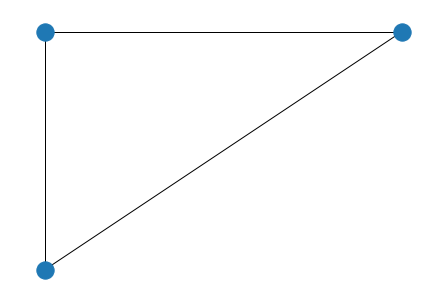

In [15]:
# ライブラリ
import networkx as nx
import matplotlib.pyplot as plt
# グラフオブジェクトの作成
G = nx.Graph()
# add_nodeで頂点の追加
G.add_node('nodeA')
G.add_node('nodeB')
G.add_node('nodeC')
# add_edgeで頂点を結び、辺の追加
G.add_edge('nodeA', 'nodeB')
G.add_edge('nodeA', 'nodeC')
G.add_edge('nodeB', 'nodeC')
# 頂点の座標位置を設定
pos = {}
pos['nodeA'] = (0,0)
pos['nodeB'] = (1,1)
pos['nodeC'] = (0,1)
# drawメソッドで描画
nx.draw(G,pos)
# showメソッドで表示
plt.show()

### ノック５４：ネットワークにノードを追加してみよう

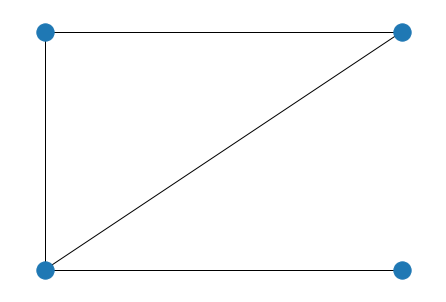

In [17]:
# ノック53のネットワークにnodeDを追加
G.add_node('nodeD')
# 頂点を結び、辺を追加
G.add_edge('nodeA', 'nodeD')
# 頂点の座標位置
pos['nodeD'] = (1,0)
# 描画
nx.draw(G, pos)
# 表示
plt.show()

### ノック５５：ルートの重みづけを実施しよう

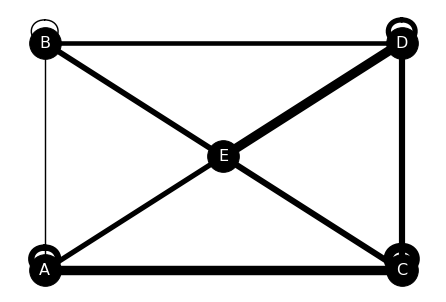

In [18]:
# A〜Eの各頂点同士のリンクの重みが記載された5行×5列のデータ
df_w = pd.read_csv('./network_weight.csv')
# A〜Eの各頂点のリンクの位置が記載された2行×5列のデータ
df_p = pd.read_csv('./network_pos.csv')

size = 10
# edge_weightsというリストを宣言
edge_weights = []
# nodeの重みデータの要素数分繰り返し処理
for i in range(len(df_w)):
    for j in range(len(df_w.columns)):
        # edge_weightsリストに、df_wの全要素に10をかけたものを代入
        edge_weights.append(df_w.iloc[i][j]*size)

# グラフオブジェクトの作成
G = nx.Graph()
# 頂点の追加
# df_wの列数分繰り返し処理
for i in range(len(df_w.columns)):
    # 同じ頂点同士を結ぶのを含めて全頂点を結び、辺の追加
    for j in range(len(df_w.columns)):
        G.add_edge(df_w.columns[i], df_w.columns[j])
        
pos = {}
# df_wの列数分繰り返し処理
for i in range(len(df_w.columns)):
    # df_wの列名を変数nodeに代入
    node = df_w.columns[i]
    # それぞれのnodeに対して、df_pの各行に記載されたデータを座標位置として設定
    pos[node] = (df_p[node][0], df_p[node][1])
# 描画
nx.draw(G, pos, with_labels=True, font_size=16, node_size=1000, node_color='k', font_color='w', width=edge_weights)
# 表示
plt.show()

↓以降の大まかな流れ  
１．最小化or最大化したい関数（目的関数）を定義  
２．目的関数の最小化or最大化を実現するために必要な制約条件を定義  
３．制約条件を満たした上で目的関数を最小化or最大化する組み合わせを選択

### ノック５６：輸送ルート情報を読み込んでみよう

In [20]:
df_tr = pd.read_csv('./trans_route.csv', index_col='工場')
df_tr.head()

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


### ノック５７：輸送ルート情報からネットワークを可視化してみよう

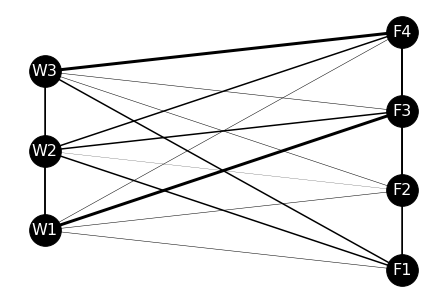

In [23]:
# trans_route_posは、W1～W3とF1～F4の各工場と倉庫の位置情報を記載した2行×7列のデータ
df_pos = pd.read_csv('trans_route_pos.csv')
# グラフオブジェクト作成
G = nx.Graph()
# add_nodeで頂点の追加
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 辺の設定＆エッジの重みのリスト化
num_pre = 0
# 重みを格納するリストを宣言
edge_weights = []
size = 0.1
# df_posの列数分繰り返し処理
for i in range(len(df_pos.columns)):
    # 全頂点の重みの追加
    for j in range(len(df_pos.columns)):
        # ループ変数が同じ頂点をもつときは処理しない
        if not (i == j):
            # 頂点を結び、列の追加
            G.add_edge(df_pos.columns[i], df_pos.columns[j])
            # エッジの重み追加
            # num_preが小さい場合にif文の中の操作を行う
            if num_pre < len(G.edges):
                # num_preを追加されたedge数で更新
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.colunms[j]] * size
                elif (df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]] * size
                        edge_weights.append(weight)

# 座標の設定
pos = {}
# df_posの列数分繰り返し処理
for i in range(len(df_pos.columns)):
    # df_pos列名を変数nodeに代入
    node = df_pos.columns[i]
    # それぞれのnodeに対して、df_posの各行に記載されたデータを座標位置として設定
    pos[node] = (df_pos[node][0], df_pos[node][1])
# 描画
nx.draw(G, pos, with_labels=True, font_size=16, node_size = 1000, node_color = 'k', font_color='w', width=edge_weights)
# 表示
plt.show()

### ノック５８：輸送コスト関数を作成しよう

In [24]:
# 最適化したい目的変数を定義
# trans_route.csvは輸送ルートを記載した3行(W1～W3)×4列(F1～F4)のデータ
df_tr = pd.read_csv('trans_route.csv', index_col='工場')

# trans_cost.csvは倉庫と工場の輸送コストを記載した3行(W1～W3)×4列(F1～F4)のデータ
df_tc = pd.read_csv('trans_cost.csv', index_col='工場')

# 輸送コストを算出する関数を定義
def trans_cost(df_tr, df_tc):
    # costという変数を作成し、0で初期化
    cost = 0
    # len(.index)でdf_tcの行数分繰り返し処理
    for i in range(len(df_tc.index)):
        # len(.columns)でdf_trの列数分繰り返し処理
        for j in range(len(df_tr.columns)):
            # 輸送ルートデータの要素（量）×輸送コストデータの要素（金額）を計算し、すべて足す
            cost += df_tr.iloc[i][j] * df_tc.iloc[i][j]
            return cost

# str関数でtrans_cost関数の戻り値（輸送コストの計算結果）を文字列型に変換し、「総輸送コスト：」に接続
print('総輸送コスト：'+ str(trans_cost(df_tr, df_tc)))

総輸送コスト：150


### ノック５９：制約条件を作ってみよう

In [25]:
# 目的変数の最適化を実現するために必要な制約条件を定義
# trans_route.csvは輸送ルート情報を記載した3行(W1～W3)×4列(F1～F4)のデータ
df_tr = pd.read_csv('trans_route.csv', index_col='工場')

# demand.csvは工場の製品生産量に対する需要を記載した1行×4列(F1～F4)のデータ
df_demand = pd.read_csv('demand.csv')

# supply.csvは倉庫が供給可能な部品数の上限を記載した1行×3列(W1～W3)のデータ
df_supply = pd.read_csv('supply.csv')

# 需要側の制約条件を満たすかどうかを審査
# len(.columns)でdf_trの列数分繰り返し処理
for i in range(len(df_demand.columns)):
    # df_demand.columns[i]はF1～F4を指す
    # df_tr[df_demand.columns[i]]はdf_tr[F〇]という意味
    # つまり、各工場のW1～W3との輸送ルート情報を抜き出している
    # sum()を使用して、各工場ごとのW1～W3の需要の合計を算出し、temp_sumに代入
    temp_sum = sum(df_tr[df_demand.columns[i]])
    
    # str関数でF1～F4の工場名、各工場ごとのW1～W3の需要の合計、工場の製品生産量に対する需要を文字列型に変換
    print(str(df_demand.columns[i]) + 'への輸送量：' + str(temp_sum) + ' (需要量：' + str(df_demand.iloc[0][i])+')')
    # 各工場ごとのW1～W3の需要の合計が工場の製品生産量に対する需要より上回る場合、需要側の制約条件を満たすと判断
    if temp_sum >= df_demand.iloc[0][i]:
        print('需要量を満たしています。')
    else:
        print('需要量を満たしていません。輸送ルートを再計算してください。')
         
# 供給側の制約条件を満たすかどうかを審査
# len(.columns)でdf_supplyの列数分繰り返し処理
for i in range(len(df_supply.columns)):
    # df_supply.columns[i]はW1～W3を指す
    # df_tr.loc[df_supply.columns[i]]はdf_tr.loc[W〇]という意味
    # つまり、各倉庫からみたF1～F4との輸送ルート情報を抜き出している
    # sum()を使用して、各倉庫からみたF1～F4への供給限界量の合計を算出し、temp_sumに代入
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    
    # str関数でW1～W3の倉庫名、各倉庫からみたF1～F4への供給限界量の合計、倉庫が供給可能な部品数の上限を文字列型に変換
    print(str(df_supply.columns[i])+ 'からの輸送量：' + str(temp_sum)+ '(供給限界：' + str(df_supply.iloc[0][i])+')')
    # 各倉庫からみたF1～F4への供給限界量の合計が倉庫が供給可能な部品数の上限より下回る場合、供給側の制約条件を満たすと判断
    if temp_sum <= df_supply.iloc[0][i]:
        print('供給限界の範囲内です。')
    else:
        print('供給限界を超過しています。輸送ルートを再計算してください。')

F1への輸送量：30 (需要量：28)
需要量を満たしています。
F2への輸送量：30 (需要量：29)
需要量を満たしています。
F3への輸送量：32 (需要量：31)
需要量を満たしています。
F4への輸送量：25 (需要量：25)
需要量を満たしています。
W1からの輸送量：35(供給限界：35)
供給限界の範囲内です。
W2からの輸送量：40(供給限界：41)
供給限界の範囲内です。
W3からの輸送量：42(供給限界：42)
供給限界の範囲内です。


### ノック６０：輸送ルートを変更して、輸送コスト関数の変化を確認しよう

In [29]:
import numpy as np

# 制約条件を満たした上で、目的変数を最適化する組み合わせを選択
# trans_route_new.csvは新しく設計し直された輸送ルート情報を記載した3行(W1～W3)×4列(F1～F4)のデータ
df_tr_new = pd.read_csv('trans_route_new.csv', index_col='工場')
print(df_tr_new)

# 新しく設計し直された輸送ルート情報を用いて総輸送コストを再計算
# str関数で再計算結果を文字列型に変換
print('総輸送コスト（変更後)：' + str(trans_cost(df_tr_new, df_tc)))

# 需要側の制約条件を計算する関数を定義
def condition_demand(df_tr, df_demand):
    
    #　df_demand.columnsは4(F1～F4の列数)を指す
    #　np.zeros()は、すべての要素を0とする配列を生成
    #　len(4)としているので、要素数が4の配列を生成し、flagとしている
    flag = np.zeros(len(df_demand.columns))
    # len(.columns)でdf_demandの列数分繰り返し処理
    for i in range(len(df_demand.columns)):
        # df_tr[df_demand.columns[i]]はdf_tr[F〇]という意味
        # つまり、各工場のW1～W3との輸送ルート情報を抜き出している
        # sum()を使用して、各工場ごとのW1～W3の需要の合計を算出し、temp_sumに代入
        temp_sum = sum(df_tr[df_demand.columns[i]])

        # 各工場ごとのW1～W3の需要の合計が工場の製品生産量に対する需要より上回る場合、需要側の制約条件を満たすと判断
        if (temp_sum >= df_demand.iloc[0][i]):
            # 制約条件を満たすとき、flag配列の要素を0から1と変換
            flag[i] = 1
            return flag

# 供給側の制約条件を計算する関数を定義
def condition_supply(df_tr, df_supply):
    # df_supply.columnsは3(W1～W3の列数)を指す
    # len(3)としているので、要素数が3の配列を生成し、flagとする
    flag = np.zeros(len(df_supply.columns))

    # len(.columns)でdf_supplyの列数分繰り返し処理
    for i in range(len(df_supply.columns)):

        # df_supply.columns[i]はW1～W3を指す
        # df_tr.loc[df_supply.columns[i]]はdf_tr.loc[W〇]という意味
        # つまり、各倉庫からみたF1～F4との輸送ルート情報を抜き出している
        # sum()を使用して、各倉庫からみたF1～F4への供給限界量の合計を算出し、temp_sumに代入
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])

        # 各倉庫からみたF1～F4への供給限界量の合計が倉庫が供給可能な部品数の上限より下回る場合、供給側の制約条件を満たすと判断
        if temp_sum <= df_supply.iloc[0][i]:
            # 制約条件を満たすとき、flag配列の要素を0から1と変換
            flag[i] = 1
            return flag

print('需要条件計算結果：' + str(condition_demand(df_tr_new, df_demand)))
print('供給条件結果：' + str(condition_supply(df_tr_new, df_supply)))

    F1  F2  F3  F4
工場                
W1  15  15   0   0
W2   5   0  30  10
W3  10  15   2  15
総輸送コスト（変更後)：150
需要条件計算結果：[1. 0. 0. 0.]
供給条件結果：[1. 0. 0.]


↑ルート変更後の総輸送コスト、需要条件計算結果（flagの各要素が0か1）、供給条件結果（需要条件計算結果と同じで0か1を表示）を確認できる。  
flagの全要素が1でないと、制約条件を満たせていないため、実行結果から、変更後のルートは不適であると分かる。